# 数据源与分析目的
数据来自：https://tianchi.aliyun.com/dataset/154063


1. 提高UV → 拉新（找出客户来源的主要渠道）；
2. 提高转化率 → 影响用户转化率的因素（随机森林），优化异常的转化环节。

# 导入库和数据

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings 
warnings.filterwarnings('ignore')

import os
os.getcwd()

'd:\\A01数据分析相关书籍\\项目'

In [2]:
excel_file = pd.ExcelFile('电商用户行为分析.xlsx')

In [1321]:
sheet_names =excel_file.sheet_names
sheet_names

['user_info',
 'home_page',
 'listing_page',
 'product_page',
 'payment_page',
 'confirmation_page']

In [1322]:
combined_df = pd.read_excel('电商用户行为分析.xlsx', sheet_name=sheet_names[0])
for sheet in sheet_names[1:]:
    df = pd.read_excel('电商用户行为分析.xlsx', sheet_name=sheet)
    combined_df = combined_df.merge(df, on='user_id', how='left', suffixes=('', '_' + sheet))

In [1323]:
combined_df.head()

,user_id,new_user,age,sex,market,device,operative_system,source,total_pages_visited,page,page_listing_page,page_product_page,page_payment_page,page_confirmation_page
0,JD_15219155734,0,29,Female,3,mobile,android,Direct,2,home_page,NaN,NaN,NaN,NaN
1,JD_lly,0,30,Female,2,mobile,android,Direct,12,home_page,listing_page,NaN,NaN,NaN
2,Jd_qazwsx012,1,30,Female,2,desktop,windows,Seo,1,home_page,listing_page,product_page,payment_page,NaN
3,jd_0215,0,29,Male,3,mobile,android,Direct,7,home_page,listing_page,product_page,NaN,NaN
4,jd_08107436,0,29,Female,1,desktop,mac,Ads,5,home_page,listing_page,NaN,NaN,NaN


In [1324]:
combined_df['user_id'].is_unique

True

In [1325]:
df = combined_df.rename(columns={'page':'home_page',
                                'page_listing_page':'listing_page',
                                'page_product_page':'product_page',
                                'page_payment_page':'payment_page',
                                'page_confirmation_page':'confirmation_page'})
df.head()

,user_id,new_user,age,sex,market,device,operative_system,source,total_pages_visited,home_page,listing_page,product_page,payment_page,confirmation_page
0,JD_15219155734,0,29,Female,3,mobile,android,Direct,2,home_page,NaN,NaN,NaN,NaN
1,JD_lly,0,30,Female,2,mobile,android,Direct,12,home_page,listing_page,NaN,NaN,NaN
2,Jd_qazwsx012,1,30,Female,2,desktop,windows,Seo,1,home_page,listing_page,product_page,payment_page,NaN
3,jd_0215,0,29,Male,3,mobile,android,Direct,7,home_page,listing_page,product_page,NaN,NaN
4,jd_08107436,0,29,Female,1,desktop,mac,Ads,5,home_page,listing_page,NaN,NaN,NaN


# 探索性数据分析

In [1326]:
# 检查数据
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   user_id              100000 non-null  object
 1   new_user             100000 non-null  int64 
 2   age                  100000 non-null  int64 
 3   sex                  99227 non-null   object
 4   market               100000 non-null  int64 
 5   device               99867 non-null   object
 6   operative_system     99783 non-null   object
 7   source               99877 non-null   object
 8   total_pages_visited  100000 non-null  int64 
 9   home_page            100000 non-null  object
 10  listing_page         73894 non-null   object
 11  product_page         49618 non-null   object
 12  payment_page         6862 non-null    object
 13  confirmation_page    2404 non-null    object
dtypes: int64(4), object(10)
memory usage: 10.7+ MB


已知数据包含缺失值，需要进一步处理。

age 是数值变量。
new_user, sex, market, device, operative_system, source 都是分类变量，应将数据类型改为object。

In [1327]:
category = ['new_user', 'sex', 'market', 'device', 'operative_system', 'source']
for col in category:
    df[col] = df[col].astype('category') 

In [1328]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   user_id              100000 non-null  object
 1   new_user             100000 non-null  int64 
 2   age                  100000 non-null  int64 
 3   sex                  99227 non-null   object
 4   market               100000 non-null  int64 
 5   device               99867 non-null   object
 6   operative_system     99783 non-null   object
 7   source               99877 non-null   object
 8   total_pages_visited  100000 non-null  int64 
 9   home_page            100000 non-null  object
 10  listing_page         73894 non-null   object
 11  product_page         49618 non-null   object
 12  payment_page         6862 non-null    object
 13  confirmation_page    2404 non-null    object
dtypes: int64(4), object(10)
memory usage: 10.7+ MB


In [1329]:
df.describe()

,new_user,age,market,total_pages_visited
count,100000.000000,100000.00000,100000.000000,100000.000000
mean,0.315250,30.39508,1.722380,5.907490
std,0.464618,8.04239,0.965203,4.199546
min,0.000000,17.00000,1.000000,1.000000
25%,0.000000,24.00000,1.000000,3.000000
50%,0.000000,30.00000,1.000000,5.000000
75%,1.000000,36.00000,2.000000,7.000000
max,1.000000,123.00000,4.000000,28.000000


## 检查缺失值

In [1330]:
# 查看缺失值
df.isnull().sum()

user_id                    0
new_user                   0
age                        0
sex                      773
market                     0
device                   133
operative_system         217
source                   123
total_pages_visited        0
home_page                  0
listing_page           26106
product_page           50382
payment_page           93138
confirmation_page      97596
dtype: int64

In [1331]:
# 缺失值占比
df.isnull().sum() / len(df)

user_id                0.00000
new_user               0.00000
age                    0.00000
sex                    0.00773
market                 0.00000
device                 0.00133
operative_system       0.00217
source                 0.00123
total_pages_visited    0.00000
home_page              0.00000
listing_page           0.26106
product_page           0.50382
payment_page           0.93138
confirmation_page      0.97596
dtype: float64

In [1332]:
# 计算每行的缺失值
df[category].isnull().sum(axis=1).value_counts()/len(df)

0    0.98758
1    0.01238
2    0.00004
Name: count, dtype: float64

## 查看数据分布

In [1333]:
# 查看数据分布
for col in category:
    print(df[col].value_counts())

new_user
0    68475
1    31525
Name: count, dtype: int64
sex
Female    60554
Male      38673
Name: count, dtype: int64
market
1    58094
3    17890
2    17795
4     6221
Name: count, dtype: int64
device
mobile     60364
desktop    39503
Name: count, dtype: int64
operative_system
windows    29700
iOS        28570
android    27328
mac         8552
other       4446
linux       1187
Name: count, dtype: int64
source
Direct    56688
Seo       28337
Ads       14852
Name: count, dtype: int64


In [1334]:
df['total_pages_visited'].value_counts()

total_pages_visited
3     22620
4     13487
5     10736
2      9460
6      8867
7      7108
8      5378
9      4007
1      3442
10     2765
11     2081
12     1604
13     1305
14     1151
15      957
16      928
18      906
17      903
19      804
20      732
21      237
22      180
23      140
24       90
25       57
26       25
27       24
28        6
Name: count, dtype: int64

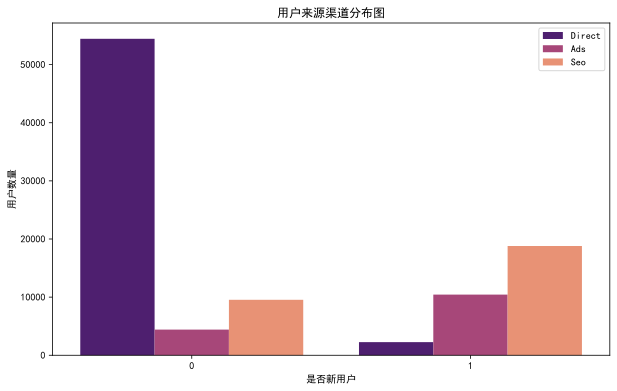

In [1397]:
# 用户来源渠道分布图
plt.figure(figsize=(10, 6))
sns.countplot(x='new_user', data=df, hue='source', palette='magma')
plt.title('用户来源渠道分布图')
plt.legend(loc='upper right')
plt.xlabel('是否新用户')
plt.ylabel('用户数量');

In [1409]:
pd.crosstab(df['new_user'], df['source'], normalize='index').style.background_gradient()

source,Ads,Direct,Seo
new_user,,,
0,0.064587,0.795841,0.139571
1,0.331386,0.071835,0.596780


可知新用户多来源于SEO，老用户多来源于Direct。

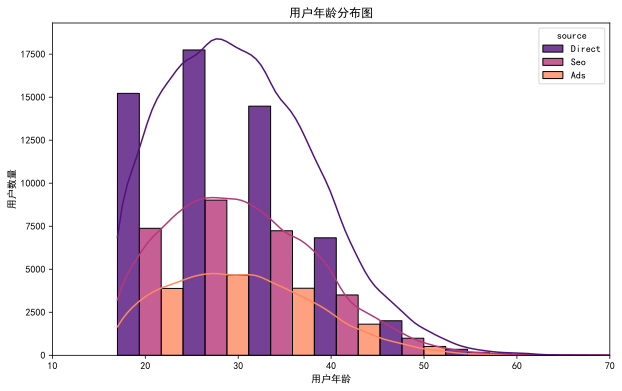

In [1399]:
# 用户年龄分布图
plt.figure(figsize=(10, 6))
sns.histplot(x='age', data=df, hue='source', bins=15, 
            palette='magma', alpha=0.8, kde=True, multiple='dodge')
plt.title('用户年龄分布图')
plt.xlim(10, 70)
plt.xlabel('用户年龄')
plt.ylabel('用户数量')
plt.title('用户年龄分布图');

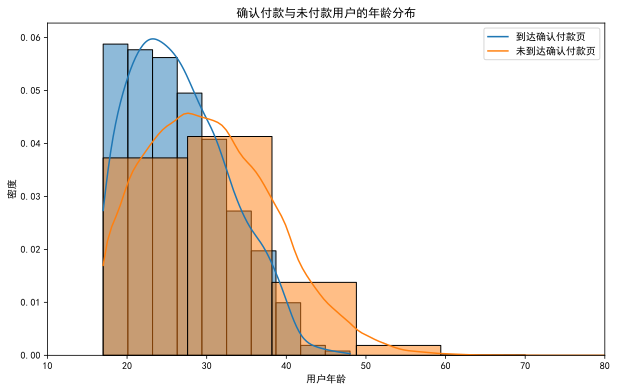

In [1430]:
# 确认付款用户的年龄分布
plt.figure(figsize=(10, 6))
sns.histplot(x='age', data=df[df['confirmation_page'].notna() == True], 
            kde= True, stat='density', bins=10, palette='magma')

# # 未付款用户的年龄分布
sns.histplot(x='age', data=df[df['confirmation_page'].notna() == False], 
            kde= True, stat='density', bins=10, palette='magma')
plt.title('确认付款与未付款用户的年龄分布')
plt.xlabel('用户年龄')
plt.xlim(10, 80)
plt.ylabel('密度')
plt.legend(['到达确认付款页', '未到达确认付款页']);

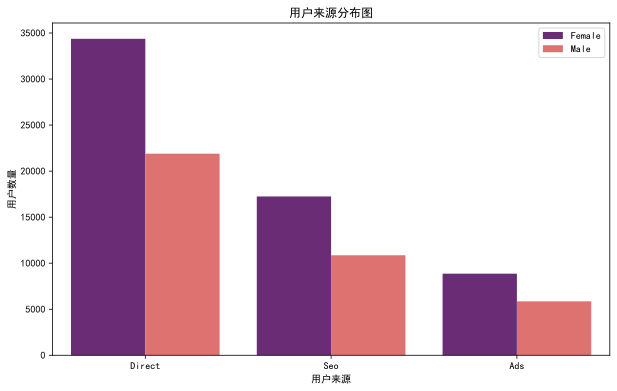

In [1400]:
# 用户来源分布图
plt.figure(figsize=(10, 6))
sns.countplot(x='source', data=df, hue='sex', palette='magma')
plt.title('用户来源分布图')
plt.legend(loc='upper right')
plt.xlabel('用户来源')
plt.ylabel('用户数量');

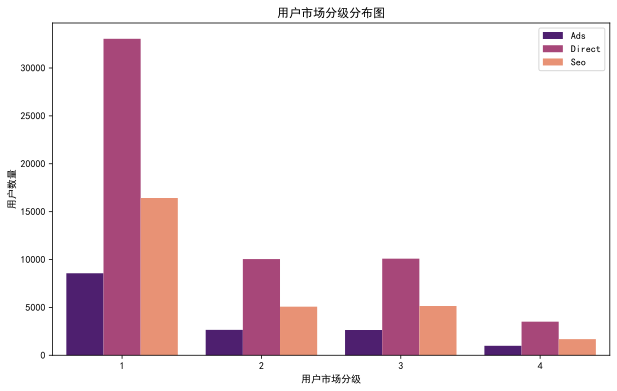

In [1401]:
# 用户市场分级分布图
plt.figure(figsize=(10, 6))
sns.countplot(x='market', data=df, hue='source', palette='magma')
plt.title('用户市场分级分布图')
plt.legend(loc='upper right')
plt.xlabel('用户市场分级')
plt.ylabel('用户数量');

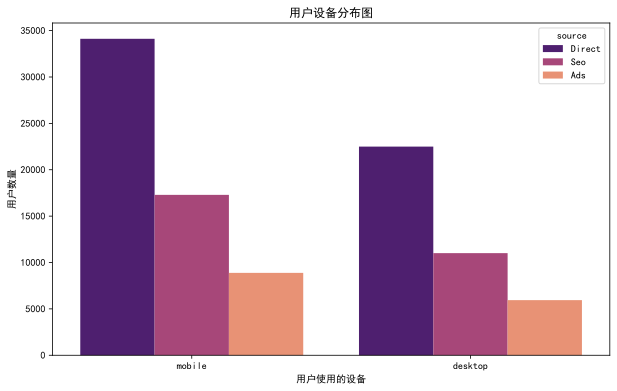

In [1402]:
# 用户使用的设备分布图
plt.figure(figsize=(10, 6))
sns.countplot(x='device', data=df, hue='source', palette='magma')
plt.title('用户设备分布图')
plt.xlabel('用户使用的设备')
plt.ylabel('用户数量');

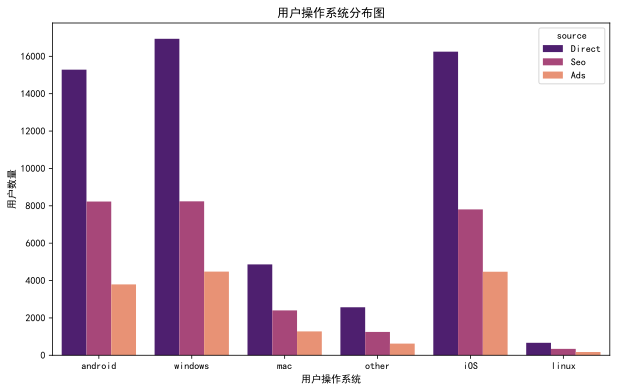

In [1403]:
# 用户操作系统分布图
plt.figure(figsize=(10, 6))
sns.countplot(x='operative_system', data=df, hue='source', palette='magma')
plt.title('用户操作系统分布图')
plt.xlabel('用户操作系统')
plt.ylabel('用户数量');

可知用户多来源于安卓,iOS,windows。

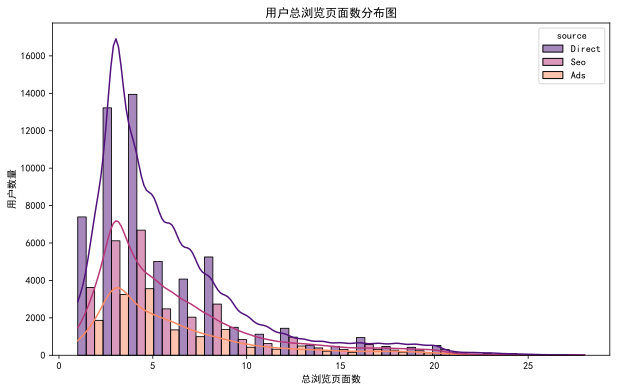

In [1404]:
# 用户总浏览页面数分布图
plt.figure(figsize=(10, 6))
sns.histplot(x='total_pages_visited', data=df, hue='source', bins=20, 
            kde=True, multiple='dodge', palette='magma')
plt.title('用户总浏览页面数分布图')
plt.xlabel('总浏览页面数')
plt.ylabel('用户数量');

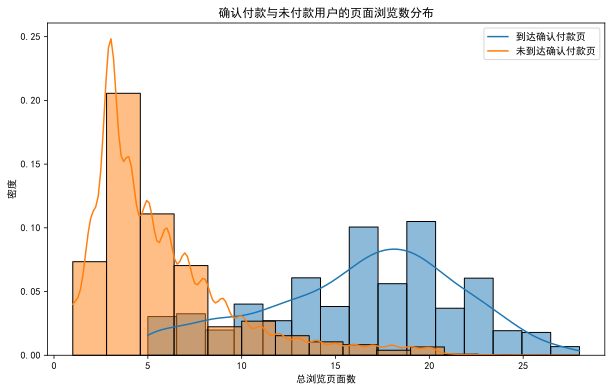

In [1431]:
# 确认支付用户的页面浏览数分布
plt.figure(figsize=(10, 6))
sns.histplot(x='total_pages_visited', data=df[df['confirmation_page'].notna() == True], bins=15,
            kde=True, stat='density', multiple='dodge', palette='magma')

# 未支付用户的页面浏览数分布
sns.histplot(x='total_pages_visited', data=df[df['confirmation_page'].notna() == False], bins=15,
            kde=True, stat='density', multiple='dodge', palette='magma')
plt.title('确认付款与未付款用户的页面浏览数分布')
plt.xlabel('总浏览页面数')
plt.ylabel('密度')
plt.legend(['到达确认付款页', '未到达确认付款页']);

## 漏斗分析
1. 已知用户的转化流程为：home_page -> listing_page -> product_page -> payment_page -> confirmation_page;
2. 通过漏斗分析，可以知道用户在不同阶段的转化率，从而对用户行为进行优化，提升转化率。
3. 漏斗分析包含：
    - 基本漏斗分析
    - 细分漏斗分析

In [1342]:
df.columns

Index(['user_id', 'new_user', 'age', 'sex', 'market', 'device',
       'operative_system', 'source', 'total_pages_visited', 'home_page',
       'listing_page', 'product_page', 'payment_page', 'confirmation_page'],
      dtype='object')

In [1343]:
df_funnel = pd.DataFrame({
    '步骤':['主页','列表页','产品页','支付页','确认付款'],
    '人数':[df['home_page'].count(), 
            df['listing_page'].count(), 
            df['product_page'].count(),
            df['payment_page'].count(), 
            df['confirmation_page'].count()]
})
df_funnel

,步骤,人数
0,主页,100000
1,列表页,73894
2,产品页,49618
3,支付页,6862
4,确认付款,2404


In [1344]:
df_funnel['向前一步'] = df_funnel['人数'].shift(1)
df_funnel['逐步转化率']= df_funnel['人数']/df_funnel['向前一步']
df_funnel['逐步转化率']=df_funnel['逐步转化率'].apply(lambda x : round(x,4))
df_funnel.drop(['向前一步'],axis=1,inplace=True)
df_funnel

,步骤,人数,逐步转化率
0,主页,100000,NaN
1,列表页,73894,0.7389
2,产品页,49618,0.6715
3,支付页,6862,0.1383
4,确认付款,2404,0.3503


In [1345]:
df_funnel['整体转化率'] = df_funnel['人数']/df_funnel['人数'].iloc[0]
df_funnel['整体转化率'] = df_funnel['整体转化率'].apply(lambda x: round(x, 4))
df_funnel

,步骤,人数,逐步转化率,整体转化率
0,主页,100000,NaN,1.0000
1,列表页,73894,0.7389,0.7389
2,产品页,49618,0.6715,0.4962
3,支付页,6862,0.1383,0.0686
4,确认付款,2404,0.3503,0.0240


### 基本漏斗图

In [1346]:
from plotly import graph_objects as go 
fig = go.Figure(go.Funnel(
    y = df_funnel['步骤'],
    x = df_funnel['人数'],
    textinfo = 'percent initial'
))
fig.update_layout(title={'text':'用户转化漏斗图'})
fig.show();

可知‘产品页→支付页’转化较差。

### 细分漏斗：性别

In [1347]:
step_1_male = (df['sex'] == 'Male') & (df['home_page'] == 'home_page')
step_1_female = (df['sex'] == 'Female') & (df['home_page'] == 'home_page')
step_2_male = (df['sex'] == 'Male') & (df['listing_page'] == 'listing_page')
step_2_female = (df['sex'] == 'Female') & (df['listing_page'] == 'listing_page')
step_3_male = (df['sex'] == 'Male') & (df['product_page'] == 'product_page')
step_3_female = (df['sex'] == 'Female') & (df['product_page'] == 'product_page')
step_4_male = (df['sex'] == 'Male') & (df['payment_page'] == 'payment_page')
step_4_female = (df['sex'] == 'Female') & (df['payment_page'] == 'payment_page')
step_5_male = (df['sex'] == 'Male') & (df['confirmation_page'] == 'payment_confirmation_page')
step_5_female = (df['sex'] == 'Female') & (df['confirmation_page'] == 'payment_confirmation_page')

trace_1 = go.Funnel(
    y =df_funnel['步骤'],
    x = [step_1_male.sum(), step_2_male.sum(), step_3_male.sum(), 
            step_4_male.sum(), step_5_male.sum()],
    name = '男性',
    textinfo = 'percent initial',
    textposition = 'inside'
)
trace_2 = go.Funnel(
    y = df_funnel['步骤'],
    x = [step_1_female.sum(), step_2_female.sum(), step_3_female.sum(), 
            step_4_female.sum(), step_5_female.sum()],
    name = '女性',
    textinfo = 'percent initial',
    textposition = 'inside'
)
fig = go.Figure([trace_1, trace_2])
fig.update_layout(title={'text':'用户转化漏斗图：性别'})
fig.show();

可知女性用户多于男性用户，女性用户的最终转化率高于男性用户。

### 细分漏斗：是否新用户

In [1348]:
step_1_new = (df['new_user'] == 1) & (df['home_page'] == 'home_page')
step_1_old = (df['new_user'] == 0) & (df['home_page'] == 'home_page')
step_2_new = (df['new_user'] == 1) & (df['listing_page'] == 'listing_page')
step_2_old = (df['new_user'] == 0) & (df['listing_page'] == 'listing_page')
step_3_new = (df['new_user'] == 1) & (df['product_page'] == 'product_page')
step_3_old = (df['new_user'] == 0) & (df['product_page'] == 'product_page')
step_4_new = (df['new_user'] == 1) & (df['payment_page'] == 'payment_page')
step_4_old = (df['new_user'] == 0) & (df['payment_page'] == 'payment_page')
step_5_new = (df['new_user'] == 1) & (df['confirmation_page'] == 'payment_confirmation_page')
step_5_old = (df['new_user'] == 0) & (df['confirmation_page'] == 'payment_confirmation_page')

trace_new = go.Funnel(
    x = [step_1_new.sum(), step_2_new.sum(), step_3_new.sum(), step_4_new.sum(), step_5_new.sum()],
    y = df_funnel['步骤'],
    name = '新用户',
    textinfo = 'percent initial'
)
trace_old = go.Funnel(
    x = [step_1_old.sum(), step_2_old.sum(), step_3_old.sum(), step_4_old.sum(), step_5_old.sum()],
    y = df_funnel['步骤'],
    name = '老用户',
    textinfo = 'percent initial'
)
fig = go.Figure([trace_new, trace_old])
fig.update_layout(title='用户转化漏斗图：新老用户', xaxis_title='访问次数', yaxis_title='步骤')
fig.show();

可知老用户的最终转化率高于新用户。

### 细分漏斗：用户来源

In [1349]:
step_1_direct = (df['source'] == 'Direct') & (df['home_page'] == 'home_page')
step_1_seo = (df['source'] =='Seo') & (df['home_page'] == 'home_page')
step_1_ads = (df['source'] == 'Ads') & (df['home_page'] == 'home_page')
step_2_direct = (df['source'] == 'Direct') & (df['listing_page'] == 'listing_page')
step_2_seo = (df['source'] =='Seo') & (df['listing_page'] == 'listing_page')
step_2_ads = (df['source'] == 'Ads') & (df['listing_page'] == 'listing_page')
step_3_direct = (df['source'] == 'Direct') & (df['product_page'] == 'product_page')
step_3_seo = (df['source'] =='Seo') & (df['product_page'] == 'product_page')
step_3_ads = (df['source'] == 'Ads') & (df['product_page'] == 'product_page')
step_4_direct = (df['source'] == 'Direct') & (df['payment_page'] == 'payment_page')
step_4_seo = (df['source'] =='Seo') & (df['payment_page'] == 'payment_page')
step_4_ads = (df['source'] == 'Ads') & (df['payment_page'] == 'payment_page')
step_5_direct = (df['source'] == 'Direct') & (df['confirmation_page'] == 'payment_confirmation_page')
step_5_seo = (df['source'] =='Seo') & (df['confirmation_page'] == 'payment_confirmation_page')
step_5_ads = (df['source'] == 'Ads') & (df['confirmation_page'] == 'payment_confirmation_page')

trace_direct = go.Funnel(
    x = [step_1_direct.sum(), step_2_direct.sum(), step_3_direct.sum(), 
            step_4_direct.sum(), step_5_direct.sum()],
    y = df_funnel['步骤'],
    name = '直接访问',  
    textinfo = 'percent initial'
)
trace_seo = go.Funnel(
    x = [step_1_seo.sum(), step_2_seo.sum(), step_3_seo.sum(), 
            step_4_seo.sum(), step_5_seo.sum()],
    y = df_funnel['步骤'],
    name = 'SEO',
    textinfo = 'percent initial'
)
trace_ads = go.Funnel(
    x = [step_1_ads.sum(), step_2_ads.sum(), step_3_ads.sum(), 
            step_4_ads.sum(), step_5_ads.sum()],
    y = df_funnel['步骤'],
    name = '广告',
    textinfo = 'percent initial'
)

fig = go.Figure([trace_direct, trace_seo, trace_ads])
fig.update_layout(title='用户转化漏斗图：用户来源', xaxis_title='转化率', yaxis_title='步骤')
fig.show();

可知用户来源的主要渠道为直接访问，其次为SEO，最后才是广告。直接访问的转化率略高于其他两个渠道。

# 拆分数据集

In [1350]:
X = df.drop(columns=['user_id','confirmation_page'], axis=1)
y = df['confirmation_page']

In [1351]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)   

In [1352]:
X_train.shape, X_test.shape

((80000, 12), (20000, 12))

# 数据预处理
- 由于随机森林对量纲不敏感，所以不对年龄特征进行归一化处理。
- 本阶段将处理缺失值以及对类别型特征进行编码。

## 处理缺失值

In [1353]:
# 缺失值占比
df.isnull().sum() / len(df)

user_id                0.00000
new_user               0.00000
age                    0.00000
sex                    0.00773
market                 0.00000
device                 0.00133
operative_system       0.00217
source                 0.00123
total_pages_visited    0.00000
home_page              0.00000
listing_page           0.26106
product_page           0.50382
payment_page           0.93138
confirmation_page      0.97596
dtype: float64

In [1354]:
df[category].isnull().sum(axis=1).value_counts()/len(df)

0    0.98758
1    0.01238
2    0.00004
Name: count, dtype: float64

In [1355]:
# 由于数据量足够大并且缺失值占比小于5%，因此直接删除分类变量中包含缺失值的行。

X_train = X_train.dropna(subset=['sex', 'device', 'operative_system', 'source'])
y_train = y_train.loc[X_train.index]

X_test = X_test.dropna(subset=['sex', 'device', 'operative_system', 'source'])
y_test = y_test.loc[X_test.index]

# 将转化过程中的缺失值转为0，非缺失值转化为1
X_train.iloc[:,8:] = X_train.iloc[:,8:].notna().astype(int)
X_test.iloc[:,8:] = X_test.iloc[:,8:].notna().astype(int)

In [1356]:
y_train = y_train.notna().astype(int)
y_test = y_test.notna().astype(int)

In [1357]:
print(X_train.isnull().sum())
print(X_test.isnull().sum())
print(y_train.isnull().sum())
print(y_test.isnull().sum())

new_user               0
age                    0
sex                    0
market                 0
device                 0
operative_system       0
source                 0
total_pages_visited    0
home_page              0
listing_page           0
product_page           0
payment_page           0
dtype: int64
new_user               0
age                    0
sex                    0
market                 0
device                 0
operative_system       0
source                 0
total_pages_visited    0
home_page              0
listing_page           0
product_page           0
payment_page           0
dtype: int64
0
0


## 分类编码

In [1358]:
category = ['sex', 'device', 'operative_system', 'source']

In [1359]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(drop='first')
X_train_encoded = encoder.fit_transform(X_train[category])
X_test_encoded = encoder.transform(X_test[category])

# 重置原始数据的索引
X_train  = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

# 编码数据转换为DataFrame格式，并设置列名
X_train_encoded_df = pd.DataFrame(X_train_encoded.toarray(), 
                                columns=encoder.get_feature_names_out(category))
X_test_encoded_df = pd.DataFrame(X_test_encoded.toarray(), 
                                columns=encoder.get_feature_names_out(category))

# 与原数据合并，并删除原有的分类
X_train = X_train.drop(columns=category).join(X_train_encoded_df)
X_test = X_test.drop(columns=category).join(X_test_encoded_df)

In [1360]:
# 检查编码后数据中的 NaN 数量
print(X_train.isnull().sum())
print(X_test.isnull().sum())

new_user                    0
age                         0
market                      0
total_pages_visited         0
home_page                   0
listing_page                0
product_page                0
payment_page                0
sex_Male                    0
device_mobile               0
operative_system_iOS        0
operative_system_linux      0
operative_system_mac        0
operative_system_other      0
operative_system_windows    0
source_Direct               0
source_Seo                  0
dtype: int64
new_user                    0
age                         0
market                      0
total_pages_visited         0
home_page                   0
listing_page                0
product_page                0
payment_page                0
sex_Male                    0
device_mobile               0
operative_system_iOS        0
operative_system_linux      0
operative_system_mac        0
operative_system_other      0
operative_system_windows    0
source_Direct              

# 训练模型

## 基准模型

In [1362]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

basemodel = DecisionTreeClassifier()

basemodel.fit(X_train, y_train)
y_pred = basemodel.predict(X_test)

In [1363]:
y_pred_train= basemodel.predict(X_train)
y_pred_prob = basemodel.predict_proba(X_test)[:,1]
y_pred_prob_train = basemodel.predict_proba(X_train)[:,1]

print(f'基础模型训练集的准确率为：{accuracy_score(y_train, y_pred_train):.4f}')
print(f'基础模型测试集的准确率为：{accuracy_score(y_test, y_pred):.4f}')
print(f'基础模型训练集的ROC-AUC得分为：{roc_auc_score(y_train, y_pred_prob_train):.4f}')
print(f'基础模型测试集的ROC-AUC得分为：{roc_auc_score(y_test, y_pred_prob):.4f}')

基础模型训练集的准确率为：0.9989
基础模型测试集的准确率为：0.9859
基础模型训练集的ROC-AUC得分为：1.0000
基础模型测试集的ROC-AUC得分为：0.8598


模型有过拟合的风险，需要进行交叉验证。

In [1364]:
from sklearn.metrics import precision_recall_curve, auc
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)
print(f'PR AUC:{pr_auc:.4f}')

PR AUC:0.7053


In [1365]:
# 使用交叉验证
from sklearn.model_selection import cross_validate
scores = cross_validate(basemodel, X_train, y_train, cv=5, scoring=['accuracy','roc_auc'])
print(scores)

{'fit_time': array([0.13017464, 0.10052347, 0.10131574, 0.10036945, 0.10559535]), 'score_time': array([0.0539403 , 0.04738927, 0.04189587, 0.03945827, 0.03929973]), 'test_accuracy': array([0.98595203, 0.98550908, 0.98677383, 0.98525503, 0.98563473]), 'test_roc_auc': array([0.86418549, 0.84267696, 0.88215048, 0.84848458, 0.85522763])}


In [1366]:
print(f'准确率：{scores['test_accuracy'].mean():.4f}+-{scores["test_accuracy"].std():.4f}')
print(f'ROC AUC：{scores['test_roc_auc'].mean():.4f}+-{scores["test_roc_auc"].std():.4f}')

准确率：0.9858+-0.0005
ROC AUC：0.8585+-0.0138


In [1367]:
importance = pd.DataFrame()
importance['特征'] = X_train.columns
importance['重要性']=basemodel.feature_importances_
importance.sort_values(by='重要性', ascending=False, inplace=True)
importance.head()

,特征,重要性
3,total_pages_visited,0.407865
7,payment_page,0.349479
1,age,0.109762
2,market,0.036628
10,operative_system_iOS,0.014732


## 随机森林模型

In [1368]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

In [1369]:
y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred_prob_train = model.predict_proba(X_train)[:,1]
print(f'基础模型训练集的准确率为：{accuracy_score(y_train, y_pred_train):.4f}')
print(f'基础模型测试集的准确率为：{accuracy_score(y_test, y_pred):.4f}')
print(f'基础模型训练集的ROC-AUC得分为：{roc_auc_score(y_train, y_pred_prob_train):.4f}')
print(f'基础模型测试集的ROC-AUC得分为：{roc_auc_score(y_test, y_pred_prob):.4f}')

基础模型训练集的准确率为：0.9889
基础模型测试集的准确率为：0.9887
基础模型训练集的ROC-AUC得分为：0.9963
基础模型测试集的ROC-AUC得分为：0.9961


In [1370]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)
print(f'PR AUC:{pr_auc:.4f}')

PR AUC:0.8715


In [1371]:
from sklearn.model_selection import cross_validate
scores = cross_validate(model, X_train, y_train, cv=5, scoring=['accuracy', 'roc_auc'])
print(scores)
print(f'准确率：{scores['test_accuracy'].mean():.4f}+-{scores["test_accuracy"].std():.4f}')
print(f'ROC AUC：{scores['test_roc_auc'].mean():.4f}+-{scores["test_roc_auc"].std():.4f}')

{'fit_time': array([1.38774323, 1.31910348, 1.32945299, 1.28520823, 1.30746722]), 'score_time': array([0.13021374, 0.12341285, 0.12977862, 0.13184023, 0.1244092 ]), 'test_accuracy': array([0.98987534, 0.98709106, 0.98993798, 0.9891153 , 0.98759651]), 'test_roc_auc': array([0.99643469, 0.99563384, 0.99668519, 0.99609122, 0.99588443])}
准确率：0.9887+-0.0012
ROC AUC：0.9961+-0.0004


In [1372]:
importance = pd.DataFrame()
importance['特征'] = X_train.columns
importance['重要性']=model.feature_importances_
importance.sort_values(by='重要性', ascending=False, inplace=True)
importance.head()

,特征,重要性
7,payment_page,0.529309
3,total_pages_visited,0.353340
6,product_page,0.042567
1,age,0.026073
8,sex_Male,0.009795


模型总结：总浏览页面数、支付页面、产品页面、性别对转化率有影响

# 总结
1. 用户来源中Direct的人数最多，其次是SEO，最后是Ads。但是老用户多来源于Direct，新用户多来源于SEO和Ads，来源于Direct的新用户最少。
2. 用户年龄集中在20-40岁。
3. 在用户市场分级中，大多用户来自一级市场，其中一级市场中的直接访问客户数量最多，并且明显多于其他市场分级。
4. 新用户使用手机购物多于电脑。操作系统中以安卓、iOS、windows为主。
5. 总浏览页面多集中在5以下，Direct、SEO、Ads渠道的总浏览页面数分布没有明显差异。
6. 漏斗分析：
    - 基本漏斗分析：‘产品页→支付页’转化较差。
    - 细分漏斗：
        - 女性用户数量明显多于男性用户，并且女性用户的高于男性。
        - 老客户数量明显多于新客户数量，并且老客户的转化率高于新客户。
        - 用户来源的转化漏斗图可以看出，Direct用户量多于SEO和Ads用户量和总和，并且直接访问的转化率也高于SEO和Ads。        
7. 通过决策树和随机森林模型的结果可以得出，总浏览页面数、用户是否达到支付页面、年龄都对转化率有影响，其中**总浏览页面数**和**用户是否达到支付页面**是提高转化率的关键。说明‘产品页→支付页’的转化存在异常，需要优化‘产品页→支付页’的转化路径。


建议：
1. 优化‘产品页→支付页’的转化路径，提升转化率。
2. 提高用户的总浏览页面数，到达确认付款页面的用户总浏览数多数在10以上。
3. 拉新应重点从SEO渠道挖掘一级市场、20-40岁的女性群体。
4. 老用户依旧是主要消费群体，需要持续关注。